# House Price Prediction Model

This notebook describes the process of building a machine learning model to predict house prices. The dataset used is from the Kaggle competition "House Prices: Advanced Regression Techniques."

## Import Libraries

The first step is to import the necessary libraries for data manipulation, visualization, and modeling.

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

## Load the Training Data

Read the training data from a CSV file.

In [69]:
train_data = pd.read_csv('house-prices/train.csv')

## Compute and Plot the Correlation Matrix

Compute the correlation matrix for the numeric columns and plot it. The correlation matrix is used as the descriptive method which helps in identifying which features have a strong relationship with the target variable (SalePrice). Features with high correlation are often more predictive and more valuable in the predictive model.

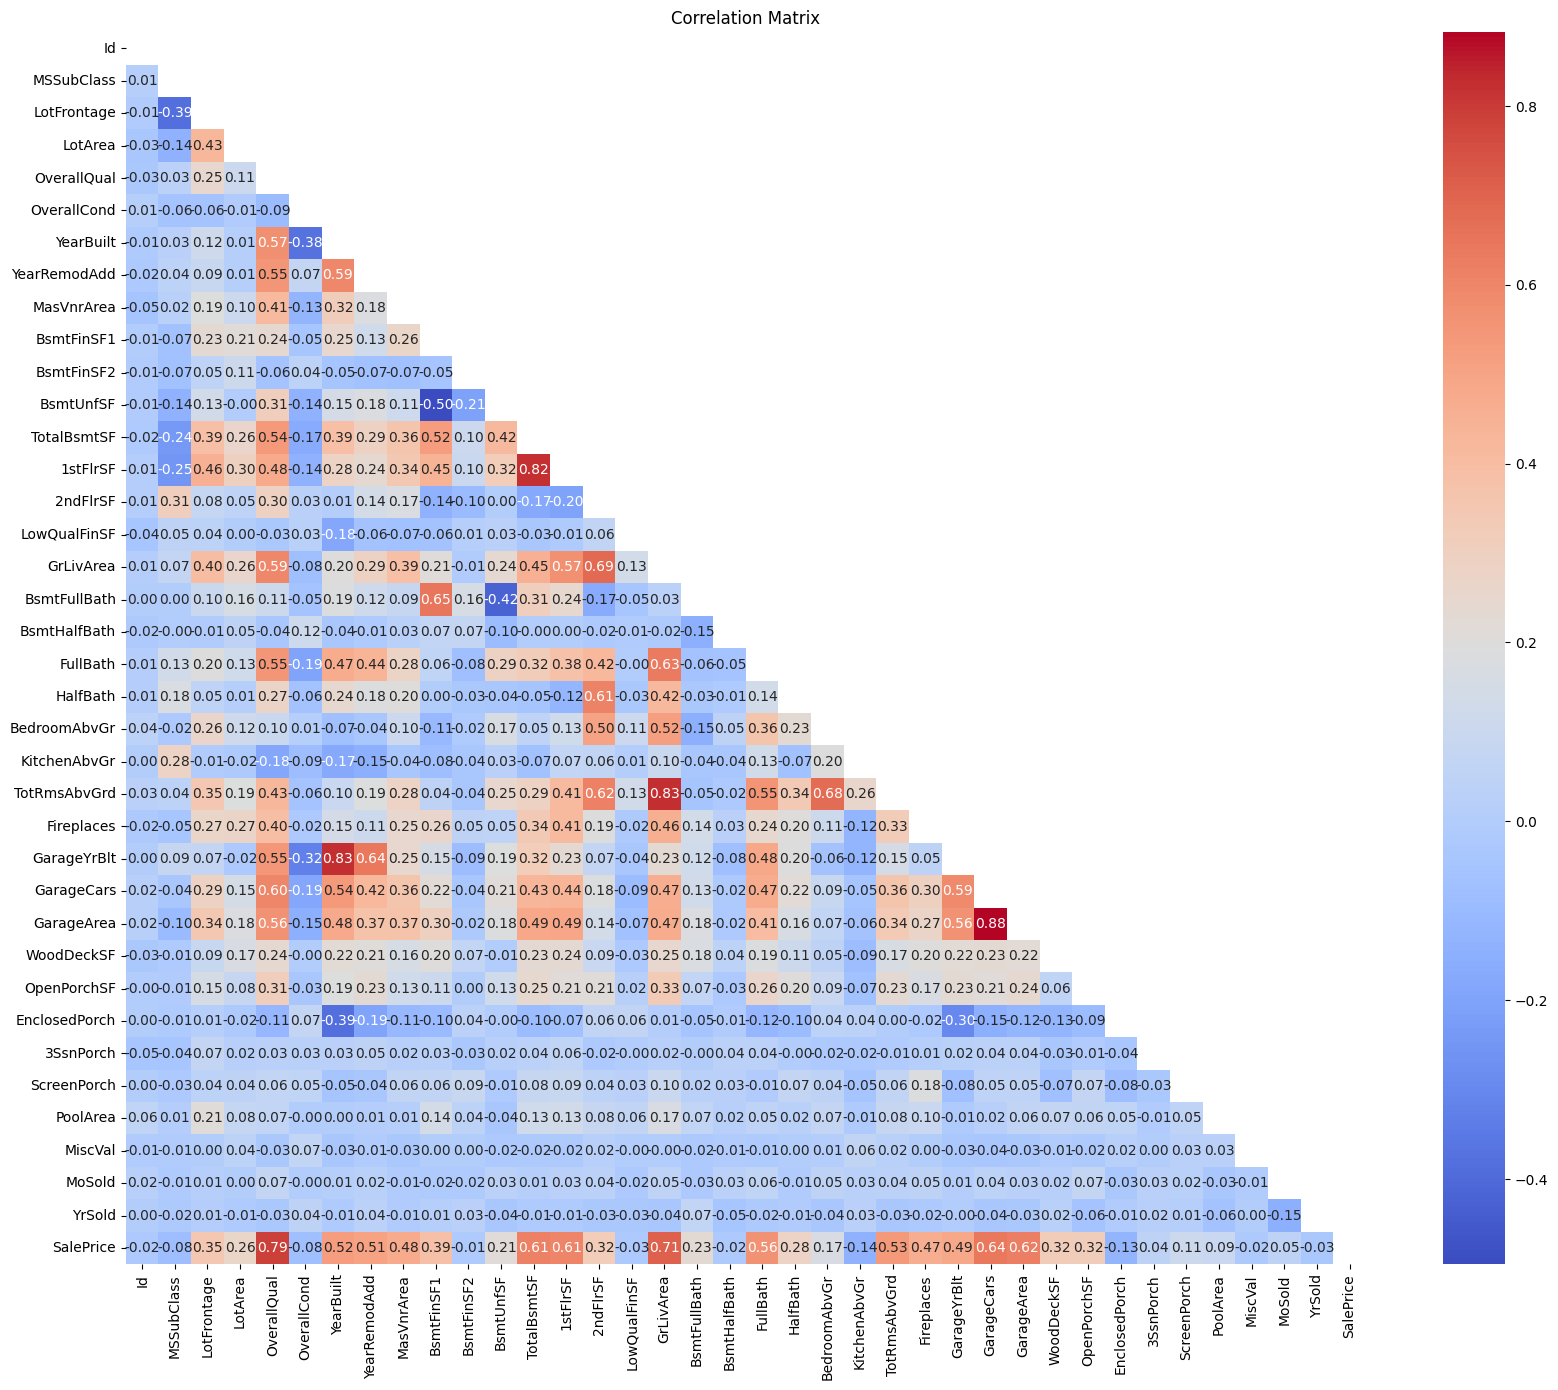

In [70]:
# Select only numeric columns
numeric_cols = train_data.select_dtypes(include=['number'])

# Compute the correlation matrix
correlation_matrix = numeric_cols.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the correlation matrix
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
plt.title('Correlation Matrix')
plt.show()


## Visualize Relationships

Define a function to visualize the relationships between features and the target variable SalePrice. This descriptive method uses the features with the strongest relationships with SalePrice to display how each one influences the SalePrice.

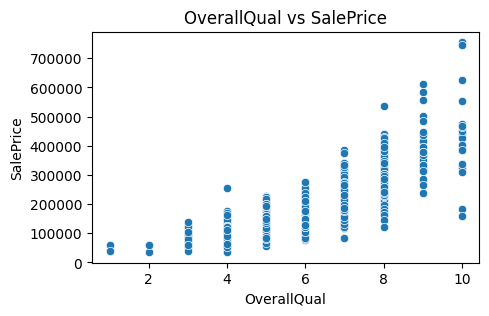

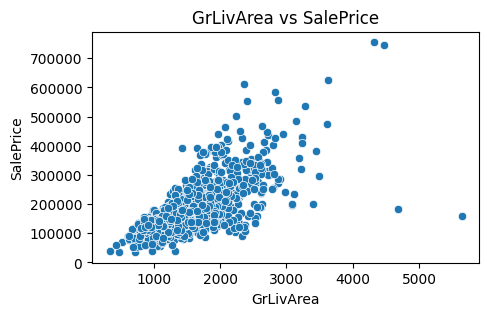

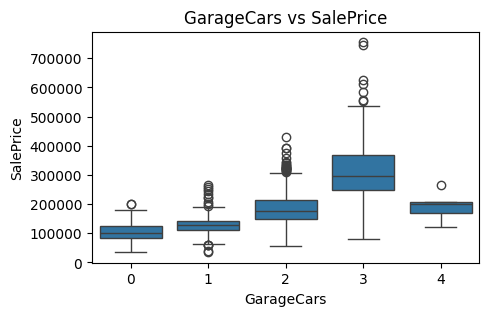

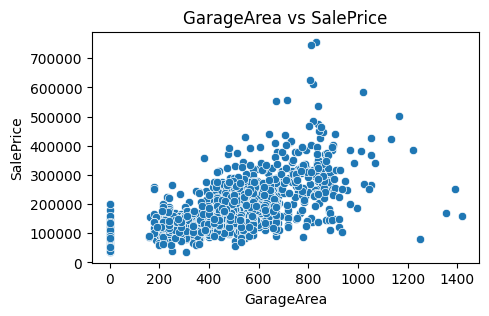

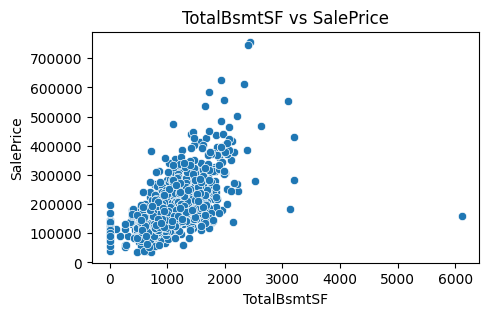

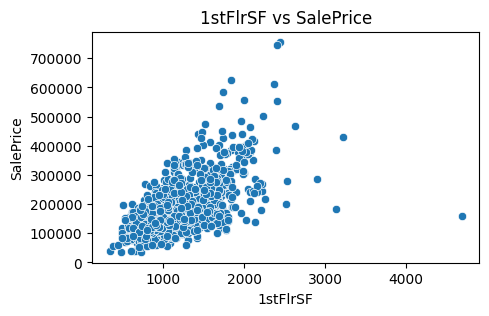

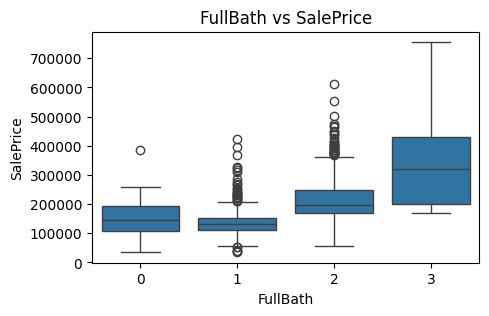

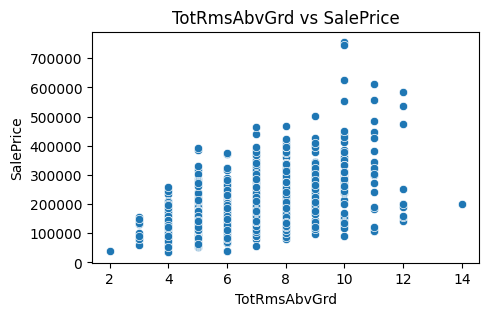

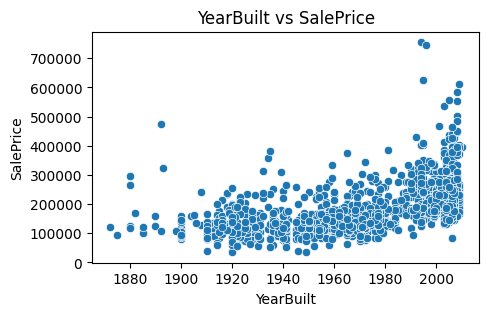

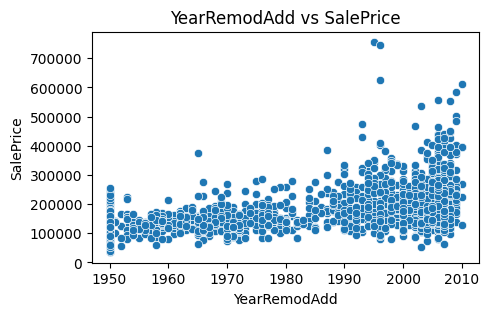

In [71]:
# Extract correlations with the target variable 'SalePrice'
corr_with_target = correlation_matrix['SalePrice'].sort_values(ascending=False)

# Function to visualize relationships
def visualize_relationships(df, features, target='SalePrice'):
    for feature in features:
        plt.figure(figsize=(5, 3))
        if df[feature].nunique() < 10:  # If the feature has less than 10 unique values, use a boxplot
            sns.boxplot(x=df[feature], y=df[target])
            plt.title(f'{feature} vs {target}')
        else:  # Otherwise, use a scatterplot
            sns.scatterplot(x=df[feature], y=df[target])
            plt.title(f'{feature} vs {target}')
        plt.show()

# Visualize relationships
key_features = corr_with_target[abs(corr_with_target) > 0.5].index.tolist()
key_features.remove('SalePrice')
visualize_relationships(train_data, key_features)

## Data Preprocessing

Handle missing values, remove outliers, and create new features.

In [72]:
# Remove outliers in 'GrLivArea'
train_data = train_data[train_data['GrLivArea'] < 4000]

# Remove outliers in 'SalePrice'
train_data = train_data[train_data['SalePrice'] < 700000]

# Fill missing values for 'LotFrontage' with the median
train_data['LotFrontage'] = train_data['LotFrontage'].fillna(train_data['LotFrontage'].median())

# Drop columns with too many missing values
columns_to_drop = ['Alley', 'PoolQC', 'Fence', 'MiscFeature']
train_data = train_data.drop(columns=[col for col in columns_to_drop if col in train_data.columns])

# Create a new feature for total area
train_data['TotalArea'] = train_data['GrLivArea'] + train_data['TotalBsmtSF']

# Log transform for skewed features
train_data['GrLivArea'] = np.log1p(train_data['GrLivArea'])
train_data['SalePrice'] = np.log1p(train_data['SalePrice'])

# Encode categorical features
train_data = pd.get_dummies(train_data)

## Split the Data

Separate the features X and the target variable y, and split into training and testing sets.

In [73]:
# Separate the features 'X' and the target variable 'y'
X = train_data.drop(columns=['SalePrice'])
y = train_data['SalePrice']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Model Training and Evaluation

Initialize, train, and evaluate a Random Forest Regressor model. Random Forest is an ensemble learning method for regression that operates by constructing multiple decision trees during training. The output of a Random Forest is the average of the predictions made by the individual trees. This nondescriptive method leverages the power of multiple trees to improve the overall performance and robustness of the model.

In [74]:
# Model Training and evaluation
# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Absolute Error: 0.10003666925168349
Mean Squared Error: 0.020719463615005436
R-squared: 0.8688130689510953


## Back-transform Predictions

Transform the predictions and actual values back to the original scale.

In [75]:
# Back-transform predictions and actual values
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
mae_original = mean_absolute_error(y_test_exp, y_pred_exp)
mse_original = mean_squared_error(y_test_exp, y_pred_exp)
r2_original = r2_score(y_test_exp, y_pred_exp)

print(f'Mean Absolute Error (original scale): {mae_original}')
print(f'Mean Squared Error (original scale): {mse_original}')
print(f'R-squared (original scale): {r2_original}')

Mean Absolute Error (original scale): 16750.089267987132
Mean Squared Error (original scale): 586536024.7262112
R-squared (original scale): 0.8882451840322508


## Hyperparameter Tuning

Use Grid Search to find the best hyperparameters for the model.

In [76]:
# Hyperparameter tuning 
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30]
}

# Initialize Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error')

# Fit Grid Search
grid_search.fit(X_train, y_train)

# Best parameters and model evaluation
best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')
best_model = RandomForestRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)

Best Parameters: {'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 200}


RandomForestRegressor(max_depth=30, max_features='sqrt', n_estimators=200,
                      random_state=42)

## Evaluate the Best Model

Evaluate the model with the best hyperparameters.

In [77]:
# Make predictions with the best model
y_pred_best = best_model.predict(X_test)

# Evaluate the best model
mae_best = mean_absolute_error(y_test, y_pred_best)
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)
print(f'Mean Absolute Error (Best Model): {mae_best}')
print(f'Mean Squared Error (Best Model): {mse_best}')
print(f'R-squared (Best Model): {r2_best}')

# Back-transform predictions and actual values for the best model
y_pred_best_exp = np.expm1(y_pred_best)
mae_original = mean_absolute_error(y_test_exp, y_pred_best_exp)
mse_original = mean_squared_error(y_test_exp, y_pred_best_exp)
r2_original = r2_score(y_test_exp, y_pred_best_exp)
print(f'Mean Absolute Error (original scale, Best Model): {mae_original}')
print(f'Mean Squared Error (original scale, Best Model): {mse_original}')
print(f'R-squared (original scale, Best Model): {r2_original}')

Mean Absolute Error (Best Model): 0.09625333910057927
Mean Squared Error (Best Model): 0.021119936664611046
R-squared (Best Model): 0.8662774420004291
Mean Absolute Error (original scale, Best Model): 16228.993420549043
Mean Squared Error (original scale, Best Model): 616472278.91017
R-squared (original scale, Best Model): 0.8825413219742405


## Feature Importances

Get and plot the top 10 feature importances. The feature importance scores provide insights into which features contribute the most to the predictions, helping to understand the model's behavior and make informed decisions based on the data.

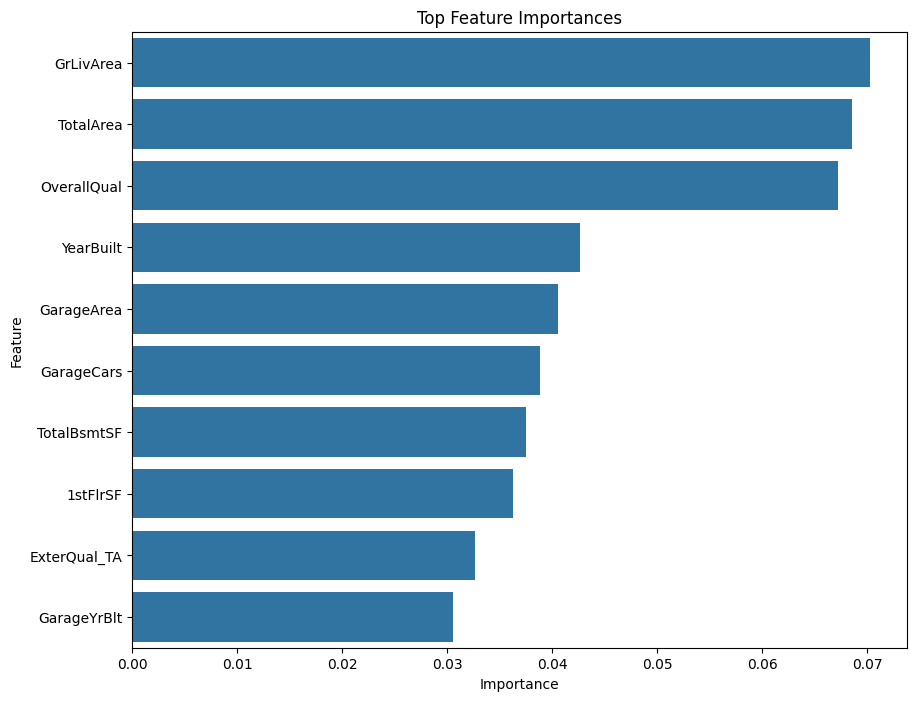

In [78]:
# Get feature importances
importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top 10 features
top_n = 10  
top_features = feature_importance_df.head(top_n)

# Plot feature importance
plt.figure(figsize=(10, 8))  
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top Feature Importances')
plt.show()

## Residual Analysis

Plot the distribution and scatter plot of residuals. The Residuals Distribution chart provides insights into the differences between the actual and predicted values of the model. The chart helps to evaluate the model's performance by visually inspecting the distribution of errors. If the residuals are centered around zero and symmetrically distributed, it suggests that the model is performing well. The Residuals vs. Predicted chart shows the relationship between the predicted values and the residuals. This chart helps to diagnose potential issues with the model. The residuals are randomly scattered and evenly spread around the zero line, which suggests that the model's errors are randomly distributed and the model is not biased towards specific predicted values.

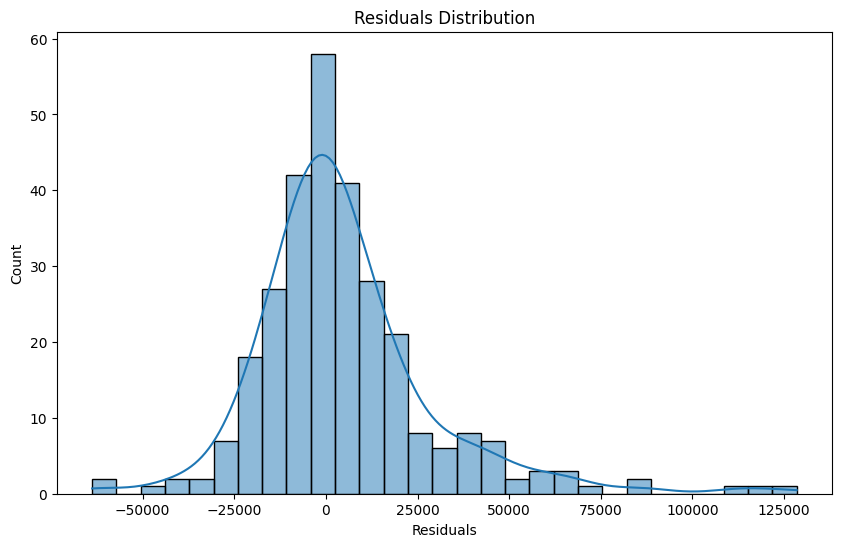

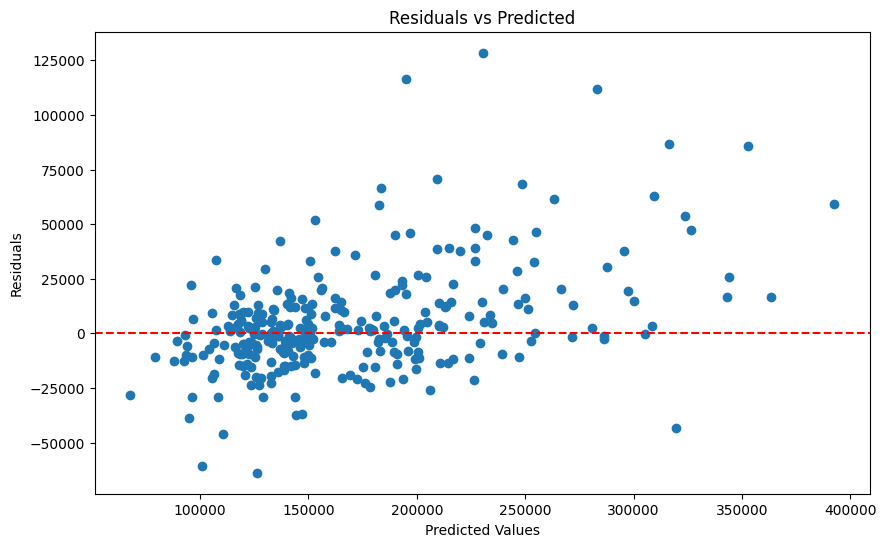

In [79]:
residuals = y_test_exp - y_pred_best_exp

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_best_exp, residuals)
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.show()

## Cross-Validation

Perform cross-validation and display the mean and standard deviation of the MAE.

In [80]:
# Cross-validation
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_absolute_error')
mean_cv_score = -cv_scores.mean()
std_cv_score = cv_scores.std()
print(f'Cross-Validation Mean MAE: {mean_cv_score}')
print(f'Cross-Validation MAE Std Dev: {std_cv_score}')

Cross-Validation Mean MAE: 0.0925842345108762
Cross-Validation MAE Std Dev: 0.0036950287577039195


## Save the Model

Save the best model using joblib.


In [81]:
# Save the model
joblib.dump(best_model, 'best_random_forest_model.pkl')

['best_random_forest_model.pkl']